<a href="https://colab.research.google.com/github/m2gu3el/Paac-DL-project/blob/main/Image_Prediction_using_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, models, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,Input, Lambda, Reshape, Conv2DTranspose, GlobalAvgPool2D, Conv1D, MaxPooling1D,LeakyReLU
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
!pip install astroNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 48.9 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from astroNN.models import Galaxy10CNN
from astroNN.datasets import load_galaxy10sdss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup


In [ ]:
images, labels = load_galaxy10sdss()


Galaxy10.h5:  99%|█████████▉| 208M/210M [00:04<00:00, 56.1MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:04, 42.1MB/s]                           


In [ ]:
labels = to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)/255

In [ ]:
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
images_train , labels_train, images_test , labels_test  = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

In [ ]:
print("images_train shape:", images_train.shape)
print("labels_train shape:", labels_train.shape)
print("images_test shape:", images_test.shape)
print("labels_test shape:", labels_test.shape)

images_train shape: (19606, 69, 69, 3)
labels_train shape: (19606, 10)
images_test shape: (2179, 69, 69, 3)
labels_test shape: (2179, 10)


In [ ]:
img_width=images.shape[1]
img_height=images.shape[2]
img_width,img_height

(69, 69)

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
codings_size = 2

inputs = Input(shape=(69,69,3), name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(3, 3))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape=tf.shape(x)

x = Flatten()(x)
x = Dense(150, activation="relu")(x)
x = Dense(100, activation="relu")(x)
codings_mean = Dense(codings_size)(x)  # μ
codings_log_var =Dense(codings_size)(x)  # γ
codings = Sampling()([codings_mean, codings_log_var]) # z
variational_encoder = models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
variational_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 69, 69, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 69, 69, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 23, 23, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 23, 23, 64)           36928     ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
decoder_inputs = Input(shape=(codings_size,), name='decoder_input')

x = Dense(23*23*64, activation='relu')(decoder_inputs)
x = Reshape((23,23,64))(x)

x=Conv2DTranspose(64,3, activation='relu', padding='same', strides=(3,3))(x)
x=Conv2DTranspose(3 ,3, activation='sigmoid', padding='same' )(x)              # Sigmoid for RGB images

variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=x)

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions]) # Combining encoder and decoder to form a VAE

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / (69*69*3))

In [ ]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(images_train, images_train, epochs=25, batch_size=32, validation_data=(images_test, images_test))

Train on 19606 samples, validate on 2179 samples
Epoch 1/25
19606/19606 [==============================] - ETA: 0s - loss: 0.0119

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


19606/19606 [==============================] - 27s 1ms/sample - loss: 0.0119 - val_loss: 0.0031
Epoch 2/25
19606/19606 [==============================] - 17s 855us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 3/25
19606/19606 [==============================] - 15s 741us/sample - loss: 0.0029 - val_loss: 0.0026
Epoch 4/25
19606/19606 [==============================] - 15s 746us/sample - loss: 0.0028 - val_loss: 0.0026
Epoch 5/25
19606/19606 [==============================] - 14s 732us/sample - loss: 0.0028 - val_loss: 0.0026
Epoch 6/25
19606/19606 [==============================] - 14s 737us/sample - loss: 0.0028 - val_loss: 0.0026
Epoch 7/25
19606/19606 [==============================] - 15s 744us/sample - loss: 0.0028 - val_loss: 0.0026
Epoch 8/25
19606/19606 [==============================] - 15s 773us/sample - loss: 0.0028 - val_loss: 0.0025
Epoch 9/25
19606/19606 [==============================] - 15s 740us/sample - loss: 0.0028 - val_loss: 0.0025
Epoch 10/25
19606/19606 [=======

In [ ]:
encoded_images_train = variational_encoder.predict(images_train/)
encoded_images_test = variational_encoder.predict(images_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [ ]:
classifier = Sequential()
classifier.add(Dense(512, activation='relu', input_shape=(codings_size,)))
classifier.add(Dropout(0.5))
classifier.add(Dense(256, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(10, activation='softmax'))

# Compile the classifier
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier using the encoded features and labels
classifier.fit(encoded_images_train, labels_train, epochs=20, batch_size=128, validation_data=(encoded_images_test, labels_test))

Train on 19606 samples, validate on 2179 samples
Epoch 1/20
19606/19606 [==============================] - 1s 44us/sample - loss: 1.9567 - acc: 0.2894 - val_loss: 1.6015 - val_acc: 0.3786
Epoch 2/20
19606/19606 [==============================] - 0s 24us/sample - loss: 1.6980 - acc: 0.3992 - val_loss: 1.4735 - val_acc: 0.5108
Epoch 3/20
19606/19606 [==============================] - 0s 25us/sample - loss: 1.5964 - acc: 0.4652 - val_loss: 1.4309 - val_acc: 0.5333
Epoch 4/20
19606/19606 [==============================] - 0s 25us/sample - loss: 1.5467 - acc: 0.4850 - val_loss: 1.4037 - val_acc: 0.5278
Epoch 5/20
19606/19606 [==============================] - 0s 25us/sample - loss: 1.5283 - acc: 0.4923 - val_loss: 1.3954 - val_acc: 0.5392
Epoch 6/20
19606/19606 [==============================] - 0s 25us/sample - loss: 1.5109 - acc: 0.4996 - val_loss: 1.3849 - val_acc: 0.5356
Epoch 7/20
19606/19606 [==============================] - 0s 25us/sample - loss: 1.5050 - acc: 0.5006 - val_loss: 1.3

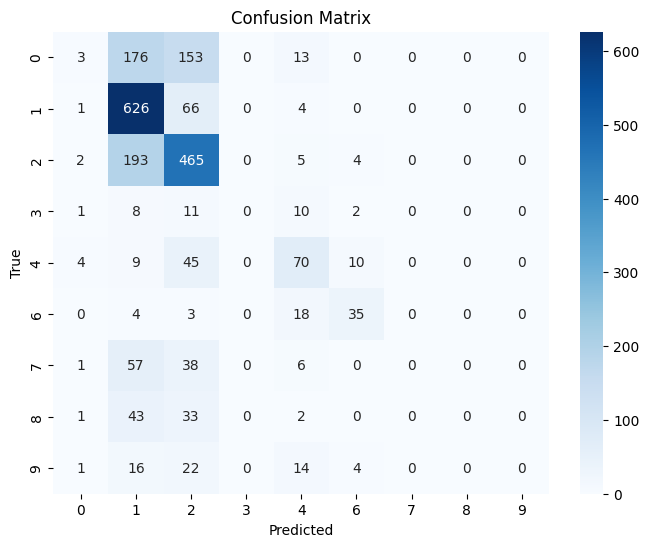

Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.01      0.02       345
           1       0.55      0.90      0.68       697
           2       0.56      0.70      0.62       669
           3       0.00      0.00      0.00        32
           4       0.49      0.51      0.50       138
           6       0.64      0.58      0.61        60
           7       0.00      0.00      0.00       102
           8       0.00      0.00      0.00        79
           9       0.00      0.00      0.00        57

    accuracy                           0.55      2179
   macro avg       0.27      0.30      0.27      2179
weighted avg       0.43      0.55      0.46      2179



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_classes), yticklabels=np.unique(true_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display the classification report
print("Classification Report:\n", classification_report(true_classes, predicted_classes))